# CIML Sequence Learning exercise

**Goal:**  Use simpleRNN, and/or GRU, and/or LSTM to learn Keras api and options.  

**Problem:** Given a sequence of a real variable and binary indicator, 
              add real values when indicator=1

**Exercise Tasks:**
<br>

1
run notebook and look at graph (near end) with **model mse vs baseline (mean)** to see performance
<br>
2 find the code cell that compile/fits the model (ie look for comments with "<<<<----" in the text), change the model to use 'gru' or 'srn', and rerun the notebook from that cell forward
<br>
3 change options that make up data:
<br>
$\;\;\;\;\;\;$ a. vary the number of steps and indicator=1 occurences, 
<br>
$\;\;\;\;\;\;$ b. and set the "t-fixed" boolean to False so that time steps when indicator=1 will be random
<br>
find some combination where some network  fail to beat baseline, but maybe a different type succeeds
<br>
3 also vary number of layers or units
<br>
4 add some code to create the 'lstm' recurrnet network (copy the 'gru' model creation code) and compare that model


**Other things to try (with more time):**

*change the logic that makes the target:* 
<br>
 try summing the numbers that is one step before when indicator=1 
<br>
 try varying the time steps and using a mask to indicate which steps are real, the input is    
    still NxTxP
    
*change input to use the random sine waves:*
<br>
 set the target to this input one step ahead, so that there is output at eeach time step, and change   the model definition to use TimeDistributed option


In [1]:
#IMPORT STATEMENTS
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1)  # for reproducibility
 
from tensorflow import keras
import tensorflow as tf


**Next cell has the sequence options to choose**

In [2]:
# =======================options to change =================
samplesize_2use=500;  #pick a large enough size
nsteps_2use    =20;    #this is T stpes

                       #<<<<<<<<<<<------------------
num1       =2          #choose number of 1s for binary variable
t_fixed    =True       #True or False,  are the times when it is 1 fixed or variable
t_fix_inds =[5,15]     #  the times to set it to 1

#Now set up parameters to run model   
numunits       =64
act2use        ='relu'  #or 'relu' or sigmoid or tanh

print('options done')

options done


**Next cell generates binary indicator variable that is 1 according to options**

In [3]:
#Generate a binary variable that is 1 exactly num1 times in each sample
#  the time steps to set it to 1 are either fixed or randomly chosen for each sample

#run tfixed= true, num1=2, nsteps=20, numhid, numlayers, srn vs gru
#
binary_num1=np.zeros((samplesize_2use,nsteps_2use,1))

if t_fixed:
    for i in range(len(t_fix_inds)):
       binary_num1[:,t_fix_inds[i]]=1
if not t_fixed:
    for i in range(samplesize_2use):
      choices_fornum1 = np.random.choice(np.arange(nsteps_2use), size=num1, replace=False, p=None) #pick out num1 indices 
      for j in choices_fornum1:
          binary_num1[i,j]=1

#print(binary_num1.shape)
#plt.plot(binary_num1[1,:],'.')
#print('binary variable generated')

**Next cells generate random sequence of numbers, or sine waves with noise**

In [4]:
#----- Generate sequence of random numbers  - 
def generate_random_series(batch_size, n_steps, noise_amp):
 series = noise_amp * (np.random.rand(batch_size, n_steps) ) # + noise that is uniform dist. between 0 to 1
 return series[..., np.newaxis].astype(np.float32)

noiseAmp_2use    =1;
my_randnum_seq   =generate_random_series(samplesize_2use,nsteps_2use,noiseAmp_2use)
print(my_randnum_seq.shape)
#plt.plot(my_randnum_seq[1,:,0])
#plt.title('a sample time series of random values unif dist')

(500, 20, 1)


In [5]:
#Generate combination of sin wave with noise, random offsets, and frequencies
def generate_time_series(batch_size, n_steps, noise_amp):
 freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size,1 )
 
 time = np.linspace(0, 1, n_steps)
 series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
 series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
 series += noise_amp * (np.random.rand(batch_size, n_steps) - 0.5) # + noise that is uniform dist. around 0
 return series[..., np.newaxis].astype(np.float32)

#generate sine waves
noiseAmp_2use  =1;
my_noisywaves  =generate_time_series(samplesize_2use,nsteps_2use,noiseAmp_2use)
print(my_noisywaves.shape)
#plt.plot(series1[1,:,0])
#plt.title('a sample time series of sin waves plus noise')

(500, 20, 1)


**Next cell make the Y target values**

Text(0.5,1,'Y train targets, mean1.5292 mean mse:0.25136')

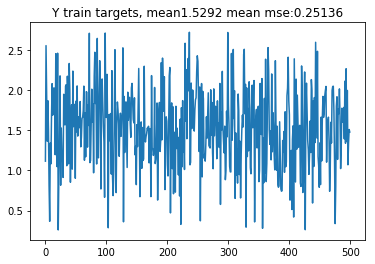

In [6]:
#now combine randnum seq,binary_num1 and make up Y values
X_train=np.concatenate((my_randnum_seq,binary_num1),axis=2)
N,T,P   =X_train.shape

Y_train =np.zeros((N,))  #1 output at each step

for i in range(N):
    locs       = np.where(X_train[i,:,1]==1)        #column 1 has indicator
    Y_train[i,]= np.sum(X_train[i,locs[0],0])  #0 has real values

ymean     =np.mean(Y_train[:,])
ymean_mse = np.mean(np.square(np.subtract(Y_train,ymean)))
plt.plot(Y_train[:,])
plt.title('Y train targets, mean'+str(round(ymean,5))+' mean mse:'+str(round(ymean_mse,5)))


## The next cells set up the model, do training, plot results
## Review the results plot and note the performance relative to baseline mse

In [7]:
# Split data
from sklearn.model_selection import train_test_split

X_train1, X_test1,Y_train1, Y_test1= train_test_split(X_train,Y_train, test_size=0.33) #use 33% for test data

print(X_train1.shape)
Y_train1.shape
print(Y_test1.shape)

(335, 20, 2)
(165,)


In [8]:
#a Simple RNN setup  
#set return_sequences=True for all recurrent layers
#except the last one, if you only care about the last output
nvar           = P   #set number of variables to P 

mysrn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(numunits, return_sequences=True, input_shape=[None,nvar]),
    keras.layers.SimpleRNN(numunits),
    keras.layers.Dense(1,activation='linear')])     

# keras.layers.TimeDistributed(keras.layers.Dense(1,activation='sigmoid'))])  for pred at each step


In [9]:
mysrn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 64)          4288      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 12,609
Trainable params: 12,609
Non-trainable params: 0
_________________________________________________________________


In [10]:
#a simple GRU RNN
mygru_model = keras.models.Sequential([
   keras.layers.GRU(numunits, activation=act2use, return_sequences=True, input_shape=[None, nvar]),
   keras.layers.GRU(numunits,activation=act2use,  return_sequences=False),
   keras.layers.Dense(1,activation='linear')])

#output for predicting at each time step
# keras.layers.TimeDistributed(keras.layers.Dense(1,activation='sigmoid'))])   


In [11]:
mygru_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 64)          13056     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 38,081
Trainable params: 38,081
Non-trainable params: 0
_________________________________________________________________


In [12]:
#create a function to be 'called' back by keras during training
my_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse', 
    verbose=1,
    patience=10,   #num  epochs with no improvement after which training will be stopped.
    mode='min',
    restore_best_weights=True)


In [13]:
numepochs=100

my_model=mysrn_model   #<<<<<<<<<----- you can change the model here and run these cells again
#my_model=mygru_model   

my_model.compile(optimizer='adam',           #or just use 'adam' to get defaults
                loss='mse',   #mse                # or try 'binary_crossentropy',
                metrics='mse')                    # 'accuracy' 

fit_result = my_model.fit(X_train1,y=Y_train1,
                    validation_data=(X_test1,Y_test1),
                    epochs=numepochs,batch_size=32,verbose=1,callbacks=[my_early_stopping])


Epoch 1/100
11/11 [==============================] - 0s 25ms/step - loss: 0.3955 - mse: 0.3955 - val_loss: 0.2274 - val_mse: 0.2274
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1768 - mse: 0.1768 - val_loss: 0.1426 - val_mse: 0.1426
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1154 - mse: 0.1154 - val_loss: 0.0848 - val_mse: 0.0848
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0712 - mse: 0.0712 - val_loss: 0.0629 - val_mse: 0.0629
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0395 - mse: 0.0395 - val_loss: 0.0344 - val_mse: 0.0344
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0072 - 

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


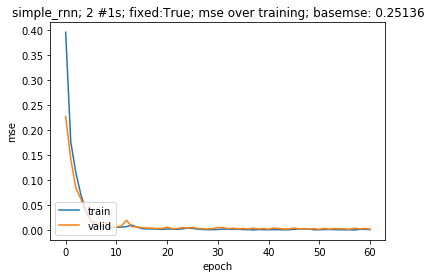

In [14]:
# list all data in history and print out performance
print(fit_result.history.keys())

metric2plot='mse'
# summarize history for accuracy
plt.figure()
plt.plot(fit_result.history[metric2plot])
plt.plot(fit_result.history['val_'+metric2plot])
plt.title(my_model.layers[0].name+'; '+str(num1)+' #1s; fixed:'+str(t_fixed)+'; '+metric2plot+' over training;'+ ' basemse: '+str(np.around(ymean_mse,5)))
plt.ylabel(metric2plot)
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower left')
plt.show()

In [15]:
#

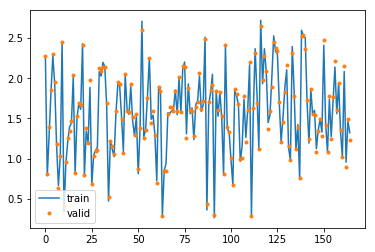

In [16]:
#Some code to get training and test set predictions
mytrain_pred=my_model.predict(X_train1[:,:,:])
mytrain_pred.shape
mytest_pred=my_model.predict(X_test1[:,:,:])
mytest_pred.shape

plt.plot(Y_test1)
plt.plot(mytest_pred,'.')
plt.legend(['train', 'valid'], loc='lower left')

In [17]:
#=============================================